# Compare tau decay distributions between Tauola and IceCube simulations

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils.hepmc_io import load_hepmc 
from collections import Counter
import numba

## Load decays

In [6]:
# TODO read this from a config file
genie_nutau_energy = 10 # GeV

decay_products = load_hepmc(f"../data/tauola_output_genie_e{genie_nutau_energy}.dat").groupby("event_num").nth[3:].sort_values("event_num")
decay_products_nopol = load_hepmc(f"../data/tauola_output_genie_nopol_e{genie_nutau_energy}.dat").groupby("event_num").nth[3:].sort_values("event_num")
decay_products_g4 = pd.read_csv(f"../data/geant4_output_e{genie_nutau_energy}.csv").sort_values("event_num")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000


In [7]:
decay_products

,event_num,pdg,E,px,py,pz
3,7,16,2.596879,0.222781,-0.683829,2.495281
4,7,-211,6.497516,-0.998736,0.610382,6.389694
8,9,16,5.663574,0.098235,-0.664739,5.623561
9,9,-211,0.355156,-0.046837,-0.120631,0.299852
10,9,111,3.584363,0.070328,0.697047,3.512637
...,...,...,...,...,...,...
2630802,999995,16,5.224114,-0.392318,-0.767595,5.152489
2630809,999996,-211,1.825069,-0.147094,-0.001521,1.813770
2630810,999996,-211,0.143598,0.025659,-0.003986,0.021608
2630808,999996,16,1.525003,-0.278366,0.643834,1.354076


In [8]:
decay_products_nopol

,event_num,pdg,E,px,py,pz
3,7,16,7.571083,-0.099063,-0.374085,7.561180
4,7,-211,1.523311,-0.676892,0.300638,1.323795
8,9,16,2.117204,0.637626,0.122778,2.015146
9,9,-211,4.418956,-0.179043,0.227436,4.407257
10,9,111,3.066932,-0.336856,-0.438536,3.013648
...,...,...,...,...,...,...
2630789,999995,16,0.559353,-0.368156,-0.089876,0.411290
2630791,999995,111,1.323485,0.175583,0.079672,1.302391
2630796,999996,-211,1.210565,-0.040580,-0.024239,1.201563
2630795,999996,16,4.613543,0.054601,0.919325,4.520679


In [9]:
decay_products_g4

,event_num,pdg,E,px,py,pz
0,0,-211,5.145260,0.041216,-0.773706,5.084670
376589,0,16,3.945190,-0.814908,0.699005,3.796290
73,0,16,3.945190,-0.814908,0.699005,3.796290
376513,0,-211,5.145260,0.041216,-0.773706,5.084670
376591,1,-211,0.646482,-0.042371,-0.103065,0.621322
...,...,...,...,...,...,...
1672500,422036,-14,0.034869,-0.017255,-0.014530,-0.026589
1672501,422036,16,3.103200,-0.782390,0.122279,3.000460
1672516,422037,111,0.540870,-0.391907,0.130323,0.322097
1672517,422037,16,2.719490,0.036533,0.781042,2.604660


In [10]:
assert decay_products["event_num"].nunique() == decay_products_nopol["event_num"].nunique() 
assert decay_products["event_num"].nunique() == decay_products_g4["event_num"].nunique()

## Compare Geant4 decay products with Tauola decay products

In [11]:
def get_particle_property(decay_products: pd.DataFrame, pdg: int, prop: str) -> tuple[pd.Series, pd.Series]:
    nutau_e = decay_products.query("pdg == 16")[prop]
    anti_nutau_e = decay_products.query("pdg == -16")[prop]
    return nutau_e, anti_nutau_e


def compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, nutau_g4, anti_nutau_g4, bins, density=None, **kwargs):
    fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

    for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau, nutau_nopol, nutau_g4), (anti_nutau, anti_nutau_nopol, anti_nutau_g4))):
        for energies, particle_type in zip(lists, ("polarized", "unpolarized (Tauola)", "unpolarized (Geant4)")):
            ax.hist(energies, bins=bins, label=f"{label} {particle_type}", density=density, histtype="step", lw=2)
            # ax.set_title(f"{label} {particle_type}")
            
    for ax in axs.flat:
        ax.set(**kwargs, ylabel="Density of number of neutrinos")
        ax.grid(True, alpha=0.5)
        ax.legend(fontsize="large")

    return fig, axs

/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='Neutrino energy [GeV]', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Neutrino energy [GeV]', ylabel='Density of number of neutrinos'>],
       dtype=object))

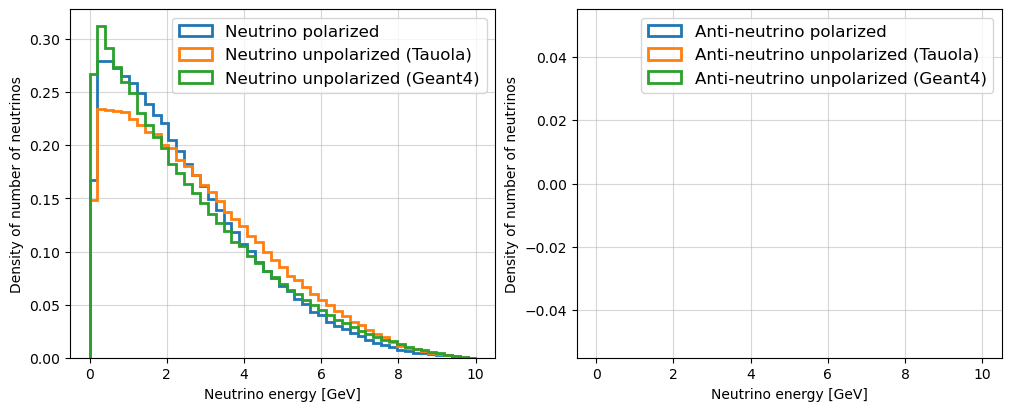

In [13]:
nutau, anti_nutau = get_particle_property(decay_products, 16, "E")
nutau_nopol, anti_nutau_nopol = get_particle_property(decay_products_nopol, 16, "E")
nutau_g4, anti_nutau_g4 = get_particle_property(decay_products_g4, 16, "E")

compare_histos(nutau, anti_nutau, nutau_nopol, anti_nutau_nopol, nutau_g4, anti_nutau_g4, 
               bins=np.linspace(0, genie_nutau_energy, 50), xlabel="Neutrino energy [GeV]", density=True)

/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/simon/miniconda3/envs/cern-skhep/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='Tau visible energy [GeV]', ylabel='Density of number of neutrinos'>,
        <Axes: xlabel='Tau visible energy [GeV]', ylabel='Density of number of neutrinos'>],
       dtype=object))

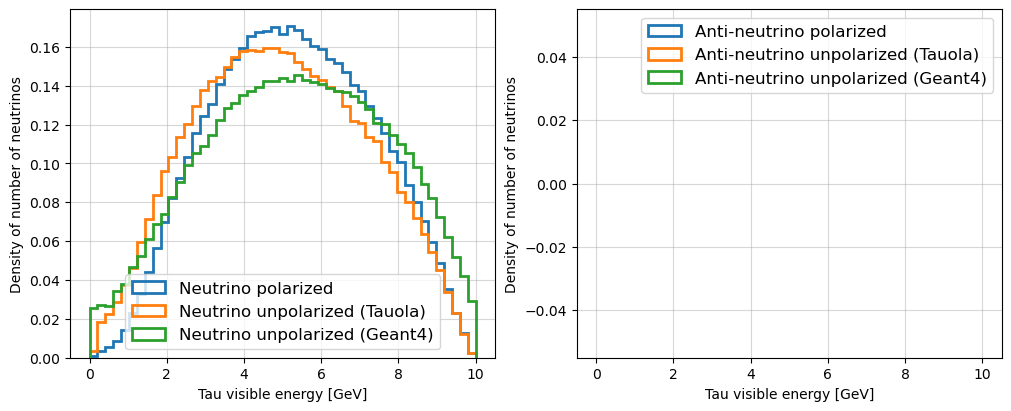

In [14]:
nutau = decay_products.query("pdg != 16").groupby("event_num")["E"].sum()
nutau_nopol = decay_products_nopol.query("pdg != 16").groupby("event_num")["E"].sum()
nutau_g4 = decay_products_g4.query("pdg != 16").groupby("event_num")["E"].sum()

compare_histos(nutau, np.array([]), nutau_nopol, np.array([]), nutau_g4, np.array([]), 
               bins=np.linspace(0, genie_nutau_energy, 50), xlabel="Tau visible energy [GeV]", density=True)

When viewing the distribution of all events (regardless of decay mode) and the neutrino energy in these cases, there is a slight shift. In the polarized simulations, the neutrinos typically have a lower energy that in the unpolarized case. This would mean that IceCube simulations using the unpolarized simulations underestimate the energy deposited in the detector, i.e., overestimate the missing energy.

## Pion momentum fraction
See Fig. 2 in the DUNE paper

In [ ]:
def filter_events(decay_products: pd.DataFrame, col: str, filter_func: callable, **kwargs) -> pd.DataFrame:
    mask = decay_products.groupby("event_num")[col].agg(filter_func, **kwargs)
    allowed_events = mask[mask > 0].index
    return decay_products[decay_products["event_num"].isin(allowed_events)]

In [52]:
@numba.njit
def is_pion_nutau_event(values: np.ndarray, index: np.ndarray) -> bool:
    # at index 0, we should have the pdg, since the event number is now the index
    # print(values)
    # return True
    return (values == -211).any() and (values == 16).any() and (values.size == 2)


# Only select events that decay to a pion and a neutrino (211 and 16)
pion_neutrino_events = filter_events(decay_products, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_nopol = filter_events(decay_products_nopol, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_g4 = filter_events(decay_products_g4, "pdg", is_pion_nutau_event, engine="numba")

In [53]:
def pion_momentum_fraction(decay_products):
    # Calculate the momentum fraction of the tau neutrino relative to the total momentum of all decay products
    pion_momentum = (
        decay_products
        .query("pdg.abs() == 211")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return pion_momentum.values / tau_momentum.values


def nu_momentum_fraction(decay_products):
    # Calculate the momentum fraction of the tau neutrino relative to the total momentum of all decay products
    nu_momentum = (
        decay_products
        .query("pdg.abs() == 16")
        .loc[:, "px":"pz"]
        .pow(2)
        .sum(axis=1)
        .pow(0.5)
    )

    decay_products = decay_products.copy()
    decay_products.loc[:, "P"] = decay_products.loc[:, "px":"pz"].pow(2).sum(axis=1).pow(0.5)
    
    tau_momentum = (
        decay_products
        .groupby("event_num")
        ["P"].sum()
    )
    return nu_momentum.values / tau_momentum.values

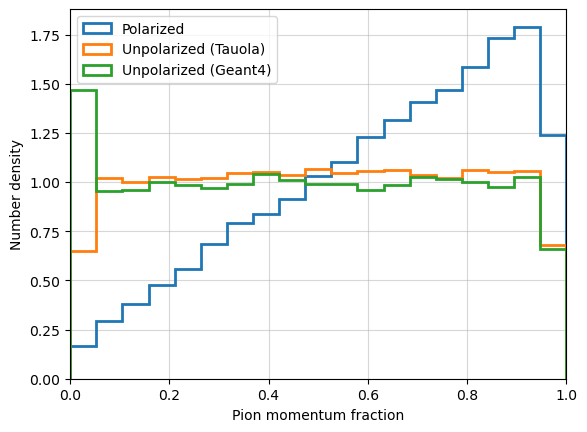

In [54]:
# Plot the momentum fraction as a histogram from 0 to 1
fig, ax = plt.subplots()
ax.hist(pion_momentum_fraction(pion_neutrino_events), bins=np.linspace(0, 1, 20), label="Polarized", histtype="step", density=True, lw=2)
ax.hist(pion_momentum_fraction(pion_neutrino_events_nopol), bins=np.linspace(0, 1, 20), label="Unpolarized (Tauola)", histtype="step", density=True, lw=2)
ax.hist(pion_momentum_fraction(pion_neutrino_events_g4), bins=np.linspace(0, 1, 20), label="Unpolarized (Geant4)", histtype="step", density=True, lw=2)
ax.set(xlim=(0, 1), xlabel="Pion momentum fraction", ylabel="Number density")
ax.grid(True, alpha=0.5)
ax.legend()

We see a clear difference between the decay using Tauola with real polarization given by GENIE and the unpolarized decay by Geant4.
A similar difference would likely be seen for the IceCube simulations.

In [ ]:
@numba.njit
def is_pion_nutau_event(values: np.ndarray, index: np.ndarray) -> bool:
    # at index 0, we should have the pdg, since the event number is now the index
    # print(values)
    # return True
    return (values == -211).any() and (values == 16).any() and (values.size == 2)


# Only select events that decay to a pion and a neutrino (211 and 16)
pion_neutrino_events = filter_events(decay_products, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_nopol = filter_events(decay_products_nopol, "pdg", is_pion_nutau_event, engine="numba")
pion_neutrino_events_g4 = filter_events(decay_products_g4, "pdg", is_pion_nutau_event, engine="numba")

In [55]:
# TODO plot momentum fraction of neutrino for various decay modes. tau -> pi0 pi0 pi- nu_tau etc. See Dune paper for details
@numba.njit
def is_pi0_pim_nutau_event(values, index) -> bool:
    return (values == -211).any() and (values == 111).any() and (values == 16).any() and (values.size == 3)

# Only select events that decay to a pi-, a neutrino and a pi0(211, 16 and 111)
pion_neutrino_events = filter_events(decay_products, "pdg", is_pi0_pim_nutau_event, engine="numba")
pion_neutrino_events_nopol = filter_events(decay_products_nopol, "pdg", is_pi0_pim_nutau_event, engine="numba")
pion_neutrino_events_g4 = filter_events(decay_products_g4, "pdg", is_pi0_pim_nutau_event, engine="numba")

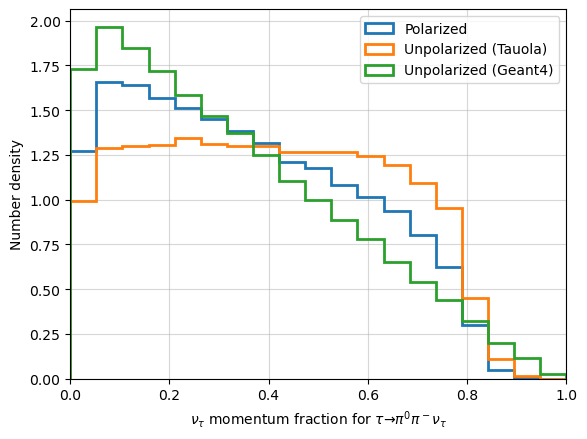

In [56]:
# Plot the momentum fraction as a histogram from 0 to 1
fig, ax = plt.subplots()
ax.hist(nu_momentum_fraction(pion_neutrino_events), bins=np.linspace(0, 1, 20), label="Polarized", histtype="step", density=True, lw=2)
ax.hist(nu_momentum_fraction(pion_neutrino_events_nopol), bins=np.linspace(0, 1, 20), label="Unpolarized (Tauola)", histtype="step", density=True, lw=2)
ax.hist(nu_momentum_fraction(pion_neutrino_events_g4), bins=np.linspace(0, 1, 20), label="Unpolarized (Geant4)", histtype="step", density=True, lw=2)
ax.set(xlim=(0, 1), xlabel=r"$\nu_\tau$ momentum fraction for $\tau\to\pi^0\pi^-\nu_\tau$", ylabel="Number density")
ax.grid(True, alpha=0.5)
ax.legend()

In [57]:
# TODO plot angular distributions of particles in tau rest frame

## Branching ratios

In [58]:
def branching_ratios(decay_products: pd.DataFrame) -> dict[tuple[int], float]:
    n_taus = decay_products.query("pdg == 16").shape[0]
    n_anti_taus = decay_products.query("pdg == -16").shape[0]
    c = Counter(tuple(sorted(a.tolist())) for i, a in decay_products.groupby("event_num")["pdg"])
    
    br = {}
    
    for pdgs, n in c.items():
        if 16 in pdgs:
            br[pdgs] = n / n_taus
        elif -16 in pdgs:
            br[pdgs] = n / n_anti_taus
        else:
            raise ValueError("No tau in the event")
    
    # Sort based on the branching ratio. Highest first
    br = dict(sorted(br.items(), key=lambda item: item[1], reverse=True))
    return br

In [59]:
branching_ratios(decay_products)

{(-211, 16, 111): 0.2528492694970595,
 (-14, 13, 16): 0.17060075159108895,
 (-12, 11, 16): 0.15218534823878418,
 (-211, 16): 0.11143309370246281,
 (-211, 16, 111, 111): 0.09160786469464835,
 (-211, -211, 16, 211): 0.08970993133319749,
 (-211, -211, 16, 111, 211): 0.04555040067482075,
 (-12, 11, 16, 22): 0.02840502513991631,
 (-211, 16, 111, 111, 111): 0.009864040678801434,
 (-321, 16): 0.0068974831650230545,
 (-14, 13, 16, 22): 0.0058928342945421975,
 (-321, -211, 16, 211): 0.005091958544017363,
 (-321, 16, 111): 0.004672565029689269,
 (-211, 16, 310): 0.004407186082769798,
 (-211, 16, 130): 0.004328994071623882,
 (-211, 16, 111, 310): 0.0028196513110193867,
 (-211, 16, 111, 130): 0.0027225036608077946,
 (-211, 16, 111, 221): 0.001670465692662746,
 (-321, -211, 16, 321): 0.0014595842080570944,
 (-211, 16, 22, 111): 0.0012984612759988437,
 (-211, -211, 16, 111, 111, 211): 0.0008932844909700074,
 (-321, 16, 111, 310): 0.0007961368407584152,
 (-321, 16, 111, 130): 0.0007487477430942238,
 

In [60]:
branching_ratios(decay_products_nopol)

{(-211, 16, 111): 0.2526028461892057,
 (-14, 13, 16): 0.17087086944777485,
 (-12, 11, 16): 0.1524080769978059,
 (-211, 16): 0.11133831550713442,
 (-211, 16, 111, 111): 0.09188509091598387,
 (-211, -211, 16, 211): 0.08870291300783342,
 (-211, -211, 16, 111, 211): 0.04560726759201778,
 (-12, 11, 16, 22): 0.02863012335382122,
 (-211, 16, 111, 111, 111): 0.010205242181983612,
 (-321, 16): 0.007053867187314886,
 (-14, 13, 16, 22): 0.00576725318573209,
 (-321, -211, 16, 211): 0.00516778110028007,
 (-321, 16, 111): 0.004809993412915424,
 (-211, 16, 310): 0.004369274804638445,
 (-211, 16, 130): 0.004146546045616746,
 (-211, 16, 111, 130): 0.0027438287547566806,
 (-211, 16, 111, 310): 0.002731981480340633,
 (-211, 16, 111, 221): 0.0017225937000933565,
 (-321, -211, 16, 321): 0.0016159682303489259,
 (-211, 16, 22, 111): 0.0012889834564660055,
 (-211, -211, 16, 111, 111, 211): 0.0008980234007364265,
 (-321, 16, 111, 310): 0.000791397930991996,
 (-321, 16, 111, 130): 0.0007060975551964515,
 (-211,

In [61]:
branching_ratios(decay_products_g4)

{(-211, 16, 111): 0.15333452247196178,
 (-12, 11, 16): 0.10873079066072587,
 (-14, 13, 16): 0.10522773537129627,
 (-211, 16): 0.06708396851111875,
 (-211, -211, 16, 16, 111, 111): 0.06280674719709604,
 (-211, -211, 16, 211): 0.05742068475996256,
 (-211, 16, 111, 111): 0.055660882181493204,
 (-12, -12, 11, 11, 16, 16): 0.043651194992377865,
 (-14, -14, 13, 13, 16, 16): 0.042577292478452995,
 (-211, -211, 16, 16): 0.027288892648364965,
 (-211, -211, -211, -211, 16, 16, 211, 211): 0.023432773518740888,
 (-211, -211, 16, 16, 111, 111, 111, 111): 0.022244860806419877,
 (-211, 11, 16, 111): 0.0013276671490646567,
 (-12, 11, 11, 16): 0.0009304703288458674,
 (-14, 11, 13, 16): 0.0008900150971569167,
 (-211, 11, 16): 0.0005663732436453106,
 (-211, -211, 11, 11, 16, 16, 111, 111): 0.0005056903961118844,
 (-211, -211, 11, 16, 211): 0.0004817850319320499,
 (-211, 11, 16, 111, 111): 0.0004413298002430992,
 (-12, -12, 11, 11, 11, 11, 16, 16): 0.00037880807854199345,
 (-14, -14, 11, 11, 13, 13, 16, 1

We see that there is no large difference ($\mathcal{O}(0.1\%)$) in branching ratio between polarized and unpolarized Tauola decays. This is good, as they should be identical, since the branching ratio is not affected by the polarization.

The Geant4 branching ratios differ by $\mathcal{O}(10\%)$ from the Tauola branching ratios. This discrepancy might be the reason for the large difference between the neutrino energy distributions between the unpolarized Tauola and Geant4 simulations. This is further strenghened by the fact that when only looking at the $\tau^- \to \pi^- \nu_tau$ decay mode, the distributions for unpolarized Tauola and Geant4 are much more similar.